# Logistic Regression Model Pipeline

This notebook provides a cell by cell execution machine learning pipeline.  Code is broken out into the following steps:
- #### Library Imports
- #### Data Import and Minor Wrangling
- #### Plot of Churn Distribution (based on user-defined metric)
- #### Split Date into Train/Test
- #### Model Instantiation and Training
- #### Display of Model Results and Interpretability
- #### Save Model for Deployment 
- #### Appendix Section: Training Model with statsmodel API

## Library Imports

In [5]:
%load_ext autoreload
%autoreload 2
pd.set_option('display.max_rows', 1500)

#models an pre-processing
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.preprocessing import StandardScaler
#from src.data_functions import wrangle
#w = wrangle()
import statsmodels.api as sm

#metrics
from sklearn.metrics import auc, f1_score, recall_score, roc_curve, precision_recall_curve, classification_report
from sklearn.metrics import confusion_matrix, plot_precision_recall_curve, plot_roc_curve
#from src.model_functions import thresh_selection, odds_to_prob

#model saving
import pickle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Import / Wrangling

In [8]:
data = pd.read_csv('../data/model/new_model_data.csv')
len(data)

3193

In [9]:
def remove_new_patients(df, threshold=2000):
    
    #new patients defined as Tenure < 400 and Recency < 400
    new_patients_nums = df[(df['Tenure'] < 400)&(data['Recency'] < 400)]['PatNum']
    new_df = df[~df['PatNum'].isin(new_patients_nums)]
    
    print(f'Total number of new patients:\t  {len(new_patients_nums)}\nTotal Count in new Dataset:\t{len(new_df)}')
    new_df = new_df[new_df["Recency"] < threshold]
    return new_df

In [10]:
fresh = remove_new_patients(data)

Total number of new patients:	  75
Total Count in new Dataset:	3118


In [11]:
fresh[fresh['Recency'].between(150,400)].sort_values(['Recency'])

,PatNum,Gender,EstBalance,InsEst,HasIns,age,seen_by_1,seen_by_2,seen_by_6,seen_by_7,seen_by_10,seen_by_15,Frequency,Tenure,Recency,Total
2461,2443,0,-1709.70,0.0,1,51.0,1,1,1,0,1,1,44,6001,151,9296.18
2704,3009,0,-938.40,0.0,1,55.0,1,1,1,0,1,1,26,5650,152,7093.40
1035,6372,0,160.80,0.0,1,14.0,1,0,0,1,0,1,5,2767,158,531.20
382,5131,1,-486.81,0.0,1,44.0,1,1,1,1,1,0,31,4298,158,5778.81
793,5916,0,-902.90,212.0,1,35.0,1,1,1,0,1,1,18,3458,160,3599.90
1164,6646,0,0.00,0.0,1,68.0,1,1,1,1,1,1,19,2387,160,5627.00
2932,3540,1,-91.20,0.0,0,44.0,1,1,1,0,0,1,57,5278,161,1899.20
2733,3073,0,20.50,0.0,1,22.0,1,1,1,0,1,0,13,5586,166,802.50
1207,6735,0,109.20,0.0,1,40.0,1,0,1,0,1,0,11,2280,167,1541.80
889,6100,0,0.20,0.0,0,56.0,1,1,0,1,0,0,6,3198,167,781.30


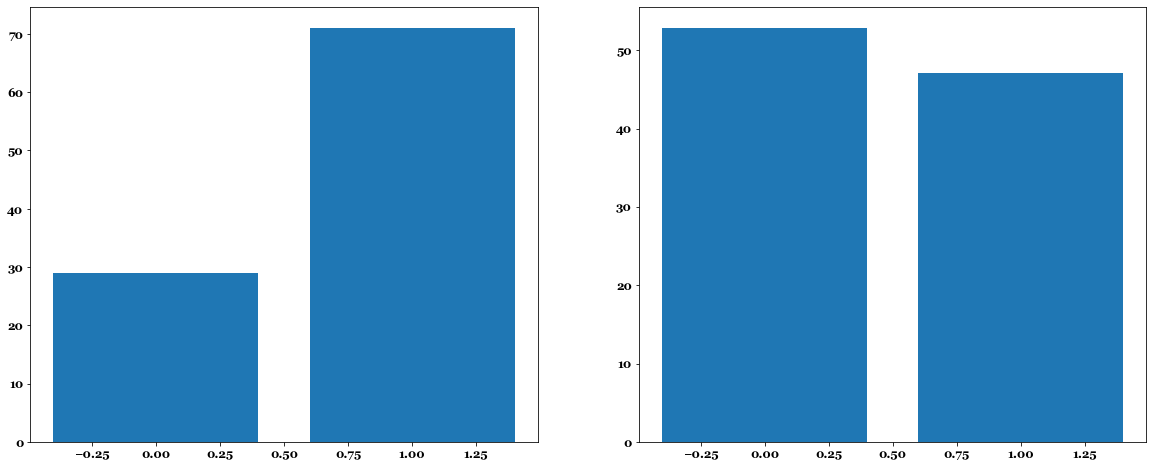

In [12]:
#Sanity check for target distribution in the dataset 
data['churn'] = np.where(data['Recency'] >= 400, 1, 0)
fresh['churn'] = np.where(fresh['Recency'] >= 400, 1, 0)
data_churn_dist = round(data['churn'].value_counts()/len(data) * 100, 2)
fresh_churn_dist = round(fresh['churn'].value_counts()/len(fresh) * 100, 2)
fig = plt.figure(figsize=(20,8))
fig1 = fig.add_subplot(1,2,1)
plot1 = plt.bar(data_churn_dist.index, data_churn_dist)
fgi2 = fig.add_subplot(1,2,2)
plot2 = plt.bar(fresh_churn_dist.index, fresh_churn_dist)

## Churn Distribution Plot

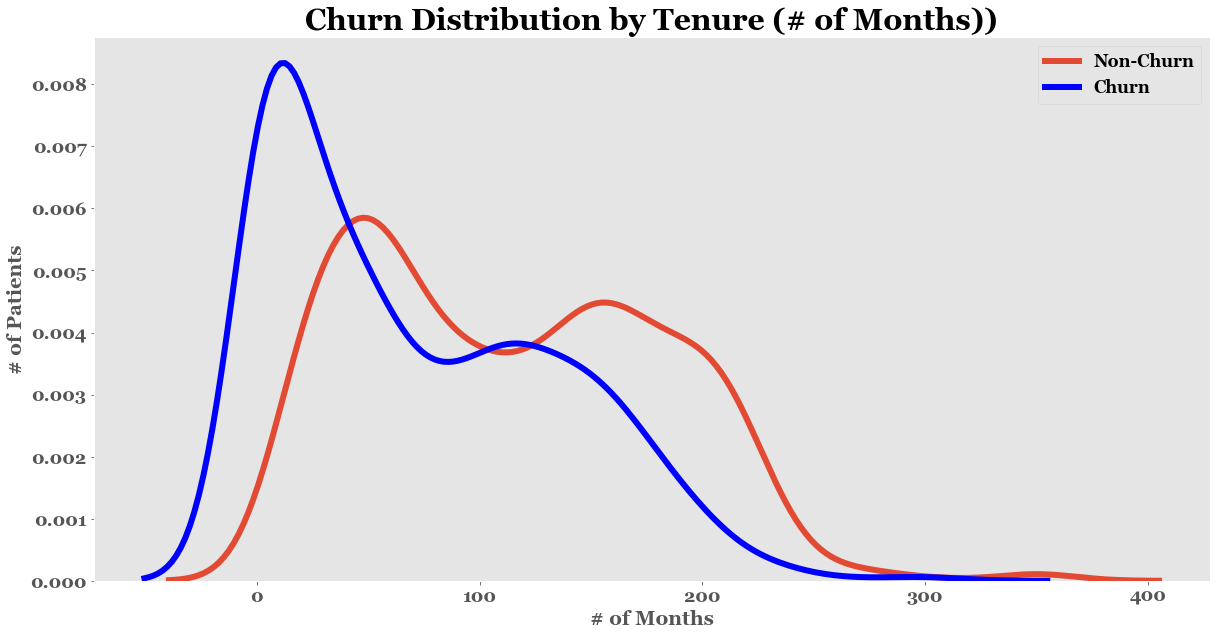

In [13]:
def plot_churn(df):
    plt.style.use('ggplot')
    #tenure_non_churn = df[df['churn'] == 0]['Tenure']/30
    #tenure_churn = df[df['churn'] == 1]['Tenure']/30
    sns.kdeplot(x=df[df['churn'] == 0]['Tenure']/30, lw=6, label='Non-Churn')
    sns.kdeplot(x=df[df['churn'] == 1]['Tenure']/30, lw=6, label='Churn', color='blue')
    #hist_churn = plt.hist(tenure_churn, bins=30, edgecolor='black', lw=2, color='blue', label='Churn')
    #hist_non_churn = plt.hist(tenure_non_churn, bins=30, edgecolor='black', lw=1.5,color='red', alpha=0.4, label='Non-churn')
    leg = plt.legend(fontsize='xx-large')
    title = plt.title('Churn Distribution by Tenure (# of Months))', fontweight='bold', fontsize=30)
    xlabel = plt.xlabel('# of Months', fontweight='bold', fontsize=20)
    ylabel = plt.ylabel('# of Patients', fontweight='bold', fontsize=20)
    xticks = plt.xticks(fontsize=18, fontweight='bold')
    yticks = plt.yticks(fontsize=18, fontweight='bold')
    plt.grid(False)
plot_churn(fresh)

## Extract Label from Data and Scale

In [14]:
def extract(df, drop_cols):
    X = df.drop(drop_cols, axis=1)
    y = df.churn
    print(X.shape, y.shape)
    return X, y

def scale_data(data):
    scaler = StandardScaler()
    Xscaled = scaler.fit_transform(data)
    print(Xscaled.shape)
    return Xscaled

In [15]:
drop_cols = ['PatNum', 'Recency', 'churn']

In [16]:
X, y = extract(fresh, drop_cols)

(1603, 14) (1603,)


In [17]:
Xscaled = scale_data(X)

(1603, 14)


## Create Train/Test split

In [18]:
def split_data(X, y, test_size=0.25):
    xtrain, xtest, ytrain, ytest = train_test_split(X,y, test_size = test_size)
    print(xtrain.shape, xtest.shape, ytrain.shape, ytest.shape)
    return xtrain, xtest, ytrain, ytest

In [19]:
xtrain, xtest, ytrain, ytest = split_data(Xscaled, y)

(1202, 14) (401, 14) (1202,) (401,)


## Instantiate Model and Train

In [20]:
lr = LogisticRegressionCV(solver='liblinear', penalty='l1', max_iter=500, cv=10, scoring='recall')

In [21]:
lr2 = LogisticRegression(solver='liblinear', penalty='l1', max_iter = 500)
print(np.mean(cross_val_score(lr2, xtrain, ytrain, scoring='recall', cv=10, verbose=1)))

0.8070175438596492


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


In [22]:
from datetime import datetime
start = datetime.now()
lr.fit(xtrain, ytrain)
total = datetime.now() - start
print(f'{total/60} minutes of run time.')

LogisticRegressionCV(cv=10, max_iter=500, penalty='l1', scoring='recall',
                     solver='liblinear')

0:00:00.003584 minutes of run time.


## Display Model Results

In [23]:
lr.score(xtrain, ytrain)
lr.score(xtest, ytest)

0.8122807017543859

0.8162162162162162

In [24]:
predictions = lr.predict(xtest)
print(classification_report(ytest, predictions))

              precision    recall  f1-score   support

           0       0.84      0.83      0.84       216
           1       0.81      0.82      0.81       185

    accuracy                           0.83       401
   macro avg       0.82      0.82      0.82       401
weighted avg       0.83      0.83      0.83       401



In [25]:
def priority_list(original_df, predicted_probas, thresh):
    df = pd.DataFrame(predicted_probas).sort_values(1, ascending=False)
    inds = df[df[1] >= thresh].index
    patients = original_df.loc[inds, :].loc[:, ['PatNum', 'tenure', 'num_visits', 'LastVisit']]
    #patients = patients.sort_values(['LastVisit', 'tenure', 'num_visits'], ascending=[False, False, False])
    return patients


In [26]:
threshold = 0.48
predicted_proba = lr.predict_proba(xtest)
predicted = (predicted_proba [:,1] >= threshold).astype('int')
print(classification_report(ytest, predicted))

              precision    recall  f1-score   support

           0       0.85      0.83      0.84       216
           1       0.81      0.82      0.82       185

    accuracy                           0.83       401
   macro avg       0.83      0.83      0.83       401
weighted avg       0.83      0.83      0.83       401



In [27]:
confusion_matrix(ytest, predictions)

array([[180,  36],
       [ 34, 151]])

In [28]:
thresh_selection(xtest, ytest, lr, 0.2, 0.57, 0.02)
curve = plot_roc_curve(lr, xtest, ytest, lw=3)
title = plt.title('ROC Curve for LR Model', fontweight='bold', fontsize=30)
ylabel = plt.ylabel('True Positive Rate', fontsize=16, fontweight='bold')
xlabel = plt.xlabel('False Positive Rate', fontsize=16, fontweight='bold')
leg = plt.legend(fontsize='xx-large', loc=10)

NameError: name 'thresh_selection' is not defined

#### Calculating Odds and Probas from Coefficients

In [29]:
def create_odds_table(df, model):
    coefs = pd.DataFrame().from_dict(dict(zip(df.columns, model.coef_[0])), orient='index').sort_values(by=0)
    coefs.rename(columns={0:'Log Odds'}, inplace=True)
    coefs['Odds'] = np.exp(coefs['Log Odds'])
    coefs['Probability'] = coefs['Log Odds'].apply(odds_to_prob)
    return coefs

create_odds_table(X, lr)

NameError: name 'odds_to_prob' is not defined

## Save Model for Deployment

In [342]:
pickle_filename = "src/bestLRmodel.pkl"  

with open(pickle_filename, 'wb') as file:  
    pickle.dump(lr, file)

In [343]:
churns = lr.predict_proba(xtest)[:,1]
nonchurns = lr.predict_proba(xtest)[:,0]

## Appendix: Logistic Regression with statsmodel API

In [344]:
log_reg = sm.Logit(ytrain, xtrain).fit()

Optimization terminated successfully.
         Current function value: 0.390556
         Iterations 8


In [345]:
print(log_reg.summary(xname=X.columns.tolist()))

                           Logit Regression Results                           
Dep. Variable:                  churn   No. Observations:                 1202
Model:                          Logit   Df Residuals:                     1188
Method:                           MLE   Df Model:                           13
Date:                Mon, 11 Jan 2021   Pseudo R-squ.:                  0.4361
Time:                        21:10:22   Log-Likelihood:                -469.45
converged:                       True   LL-Null:                       -832.56
Covariance Type:            nonrobust   LLR p-value:                8.494e-147
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Gender        -0.0585      0.083     -0.705      0.481      -0.221       0.104
EstBalance     0.1374      0.124      1.105      0.269      -0.106       0.381
InsEst        -1.1963      0.299     -4.005      0.0